### RQ4: - Hypothesis testing for the presence or absence of Pareto Principle for the number of commits made by the software developers. Specifically, we will study if 80% of commit message come from 20% of committers for a random sample of 100,000 repositories (at each repository level).

In [2]:
import pandas as pd
import chardet
import nltk
from nltk.corpus import stopwords
import pickle
import pyarrow.parquet as pq
import numpy
import os
import vaex as vx
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import math
import glob
from scipy.optimize import curve_fit
import time
from random import sample
from platform import python_version

#### Using VAEX dataframes for larger 

In [3]:
# VAEX DATAFRAME
df= []

In [4]:
# READ ALL THE PARQUET FILE
df = vx.open('/data/fdac21/eawoc//processed_data/*.parquet')

In [8]:
# COLUMN NAMES
columns = ["projectID", "commitID", "author", "committer", 
           "authorTime", "committerTime", "authorTimezone", 
           "committerTimezone", "commitMessage"]

In [9]:
# Review the data
df.head()

#,projectID,commitID,author,committer,authorTime,committerTime,authorTimezone,committerTimezone,commitMessage
0,wildfly_wildfly,00001a1a9d1552584eee5e62ab11d7b86408c0d8,ochaloup <ochaloup@redhat.com>,ochaloup <ochaloup@redhat.com>,1488898509,1489149067,+0100,+0100,'[JBTM-2858] adding JAXRS filter to import trans...
1,wildfly_wildfly,00010938ae7227834e2c69a9c3c71c95d3f3483d,Stuart Douglas <stuart.w.douglas@gmail.com>,Stuart Douglas <stuart.w.douglas@gmail.com>,1458105079,1458105079,+1100,+1100,WFCORE-1436 Undertow 1.3.19.Final
2,wildfly_wildfly,000183c08f9e7d9770ad8216acb565552da7bfb0,Jeff Mesnil <jmesnil@gmail.com>,Jeff Mesnil <jmesnil@gmail.com>,1332344580,1332436142,+0100,+0100,'[JBPAPP-8184] Connection factory failure\\n* add...
3,wildfly_wildfly,0001a3f7a195b75e563280609636faa249877036,jaikiran <jaikiran.pai@gmail.com>,baranowb <baranowb@gmail.com>,1328294482,1328611298,+0530,+0100,Upgrade to 2.0.0 of jboss-ejb3-ext-api
4,wildfly_wildfly,00024ccfa6fa6fd6426de7bb1d8d494798b384fe,James R. Perkins <jperkins@redhat.com>,GitHub <noreply@github.com>,1583899415,1583899415,-0700,-0700,'Merge pull request #13102 from kabir/WFLY-13222...
5,wildfly_wildfly,0002dbdc7b6cb98e6387cc5f0d11bb93229c5381,Kabir Khan <kkhan@redhat.com>,GitHub <noreply@github.com>,1491037874,1491037874,+0100,+0100,'Merge pull request #9883 from jbosstm/WFLY-8485...
6,wildfly_wildfly,000325d9bb03ceffbe9e7b4756a5566b273040d1,Brian Stansberry <brian.stansberry@redhat.com>,Brian Stansberry <brian.stansberry@redhat.com>,1503172204,1505862581,-0500,-0500,Minor cleanup
7,wildfly_wildfly,0003c4792f52061661cc9db421c7741bc4df8284,Richard Achmatowicz <rachmatowicz@jboss.com>,Paul Ferraro <paul.ferraro@redhat.com>,1370975878,1374591017,-0400,-0400,"[WFLY-1430] Add in XML processing, test cases."
8,wildfly_wildfly,0004ba7ca70b15a48fe6460ec5375c86cd8dc19d,Scott Marlow <smarlow@redhat.com>,Scott Marlow <smarlow@redhat.com>,1463689533,1473273893,-0400,-0400,'add org.wildfly.extension.nosql.common dependen...
9,wildfly_wildfly,000703aae4a2cc2cc0f1c4a9a03ae391bb76def0,Pelisse Romain <belaran@redhat.com>,GitHub <noreply@github.com>,1470623929,1470623929,+0000,+0000,'Merge 03a1e02b4aa392ec3d8914846eee615232f45d89 ...


In [12]:
# Generate value count for project name and number of commits made in it. (takes time)
px = pd.DataFrame(df.projectID.value_counts())

In [19]:
# assign the elements
proj_commits=px[0]

Text(0, 0.5, '# of commits')

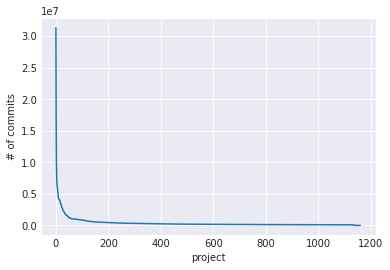

In [20]:
# some exploratory statistics. plot all the committ messages per project

sns.set_style('darkgrid')
p=sns.lineplot(data=proj_commits.values)
p.set_xlabel('project')
p.set_ylabel('# of commits')

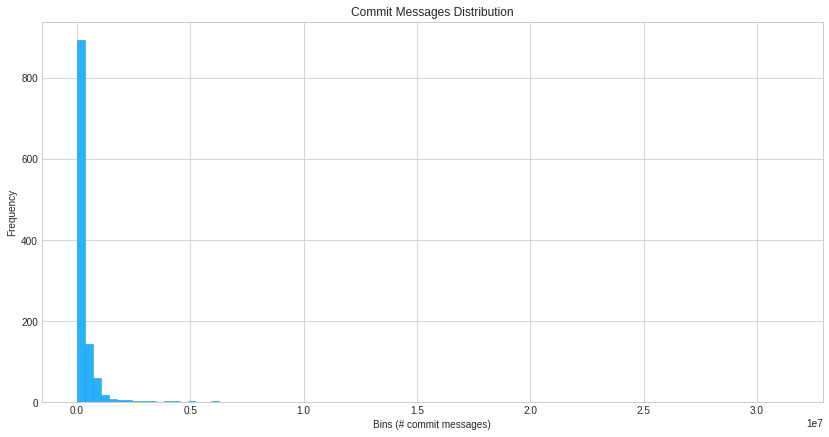

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


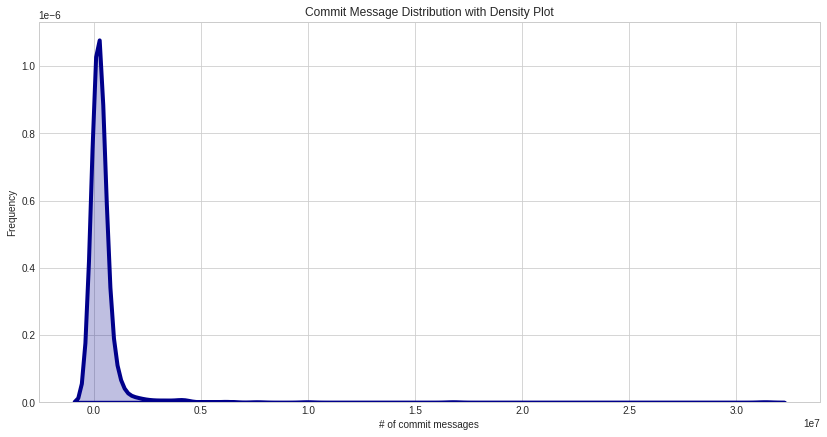

In [21]:
# HISTOGRAM, DENSITY PLOT, ETC OF ALL THE MESSAE COMBINED. 

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(proj_commits.values, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Commit Messages Distribution') 
plt.xlabel('Bins (# commit messages)') 
plt.ylabel('Frequency') 
plt.show()

plt.figure(figsize=(14,7)) # Make it 14x7 inch

sns.distplot(proj_commits.values, hist=False, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'shade': True})
plt.legend()
plt.xlabel('# of commit messages')
plt.ylabel('Frequency')
plt.title('Commit Message Distribution with Density Plot')

#fig = plt.figure(figsize=(10,7))
#plt.boxplot(proj_commits.values)
#plt.savefig('ao.png')
plt.show()


#### SELECT RANDOM 1000 PROJECT AND PERFORM DESCRIPTIVE STATS AND DISPERSION

### [4] Hypothesis testing for the presence or absence of Pareto Principle for the number of commits made by the software developers. Specifically, we will study if 80% of commit message come from 20% of committers for a random sample of 100,000 repositories (at each repository level).

Calculating best minimal value for power law fit
2.163448638397054%
98980.0
-0.7139325114870143 0.48887106277732084 <powerlaw.Fit object at 0x7fe0b507d760>


Text(0, 0.5, 'p(X)')

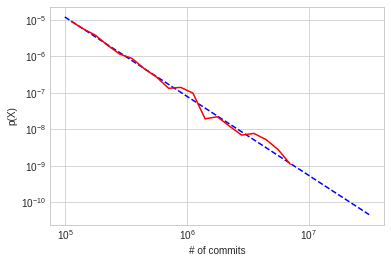

In [22]:
# We start by evaluating if the number of commits in the list of project fit pareto distribution (power law distribution)

import powerlaw
data = proj_commits.values # data can be list or numpy array
results = powerlaw.Fit(data)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')
print (R, p, results)
results.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
figPDF = results.plot_pdf( color= 'r', )
figPDF.set_xlabel("# of commits")
figPDF.set_ylabel("p(X)")

### [5.4] Develop static and interactive visualizations to demonstrate the findings.